## Importing the Required Libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats 
from scipy.stats import pearsonr, f_oneway, ttest_ind, chi2_contingency
from IPython.display import display
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

## Inspecting the Dataset

We begin by loading the dataset and examining the first few rows:

In [31]:
# Load the dataset 
df_raw = pd.read_csv('../data/student_performance.csv')

# Display first few rows and summary statistics of numeric columns
pd.set_option('display.max_columns', None)
display(df_raw.head())  
display(df_raw.describe()) 

# Print columns with null values and their counts
null_counts = df_raw.isnull().sum()
print(null_counts[null_counts > 0] if not null_counts[null_counts > 0].empty else 'Dataframe has no null values')
print(f'columns: {len(df_raw.columns)}, rows: {len(df_raw)}')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


Dataframe has no null values
columns: 33, rows: 649


**Observations**
- There are 33 columns, including the target variable G3.
- There are 649 observed students
- Numeric columns show expected ranges and summary statistics.
- There are no missing values, making preprocessing simpler.

## Preprocessing the Data

### Binary Encoding

Binary categorical features (e.g., sex, schoolsup) are mapped to 0/1 for modeling:

In [32]:
# ---------------  Convert Binary Nominal Features to Binary Numeric -----------------

# Define binary mappings
binary_mappings = {
    'school': {'GP': 1, 'MS': 0},
    'sex': {'M': 1, 'F': 0},
    'address': {'U': 1, 'R': 0},
    'famsize': {'GT3': 1, 'LE3': 0},
    'Pstatus': {'T': 1, 'A': 0},
    'schoolsup': {'yes': 1, 'no': 0},
    'famsup': {'yes': 1, 'no': 0},
    'paid': {'yes': 1, 'no': 0},
    'activities': {'yes': 1, 'no': 0},
    'nursery': {'yes': 1, 'no': 0},
    'higher': {'yes': 1, 'no': 0},
    'internet': {'yes': 1, 'no': 0},
    'romantic': {'yes': 1, 'no': 0}
}

# Make a copy of the raw dataframe
df = df_raw.copy()

# Apply mappings column by column and ensure integer type
for col, mapping in binary_mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping).astype(int)

# Save the preprocessed dataset
df.to_csv('../data/student_preprocessed.csv', index=False)

# Display the updated dataframe
display(df.head())
display(df.info())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,18,1,1,0,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11
1,1,0,17,1,1,1,1,1,at_home,other,course,father,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11
2,1,0,15,1,0,1,1,1,at_home,other,other,mother,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12
3,1,0,15,1,1,1,4,2,health,services,home,mother,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14
4,1,0,16,1,1,1,3,3,other,other,home,father,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    int64 
 1   sex         649 non-null    int64 
 2   age         649 non-null    int64 
 3   address     649 non-null    int64 
 4   famsize     649 non-null    int64 
 5   Pstatus     649 non-null    int64 
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    int64 
 16  famsup      649 non-null    int64 
 17  paid        649 non-null    int64 
 18  activities  649 non-null    int64 
 19  nursery     649 non-null    int64 
 20  higher    

None

**Explanation**
- Binary variables are converted for computation in models like OLS and tree-based algorithms.
- Four multi-category nominal variables remain (dtype: object) and will be one-hot encoded later 
- Data set is clean and ready for analysis

## Exploratory Data Analysis

In [33]:
# Load the saved preprocessed dataset
df = pd.read_csv('../data/student_preprocessed.csv')

# --- Define variable types ---

# Binary Categorical variables (0/1)
bin_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
'higher', 'internet', 'romantic']
# Ordinal Categorical variables (1-5 scale)
ord_vars = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
# Nominal Categorical variables (more than 2 categories)
nom_vars = ['Mjob', 'Fjob', 'reason', 'guardian']
# Continuous Numeric variables
cont_vars = ['age', 'absences', 'G1', 'G2', 'G3']
# Categorical variables (including binary and ordinal)
cat_vars = bin_vars + ord_vars + nom_vars
# Numeric variables (including continuous and ordinal)
numeric_vars = cont_vars + ord_vars
# All variables
all_vars = cat_vars + cont_vars

### Distributions of Categorical Variables

We visualize the count of students for each category:

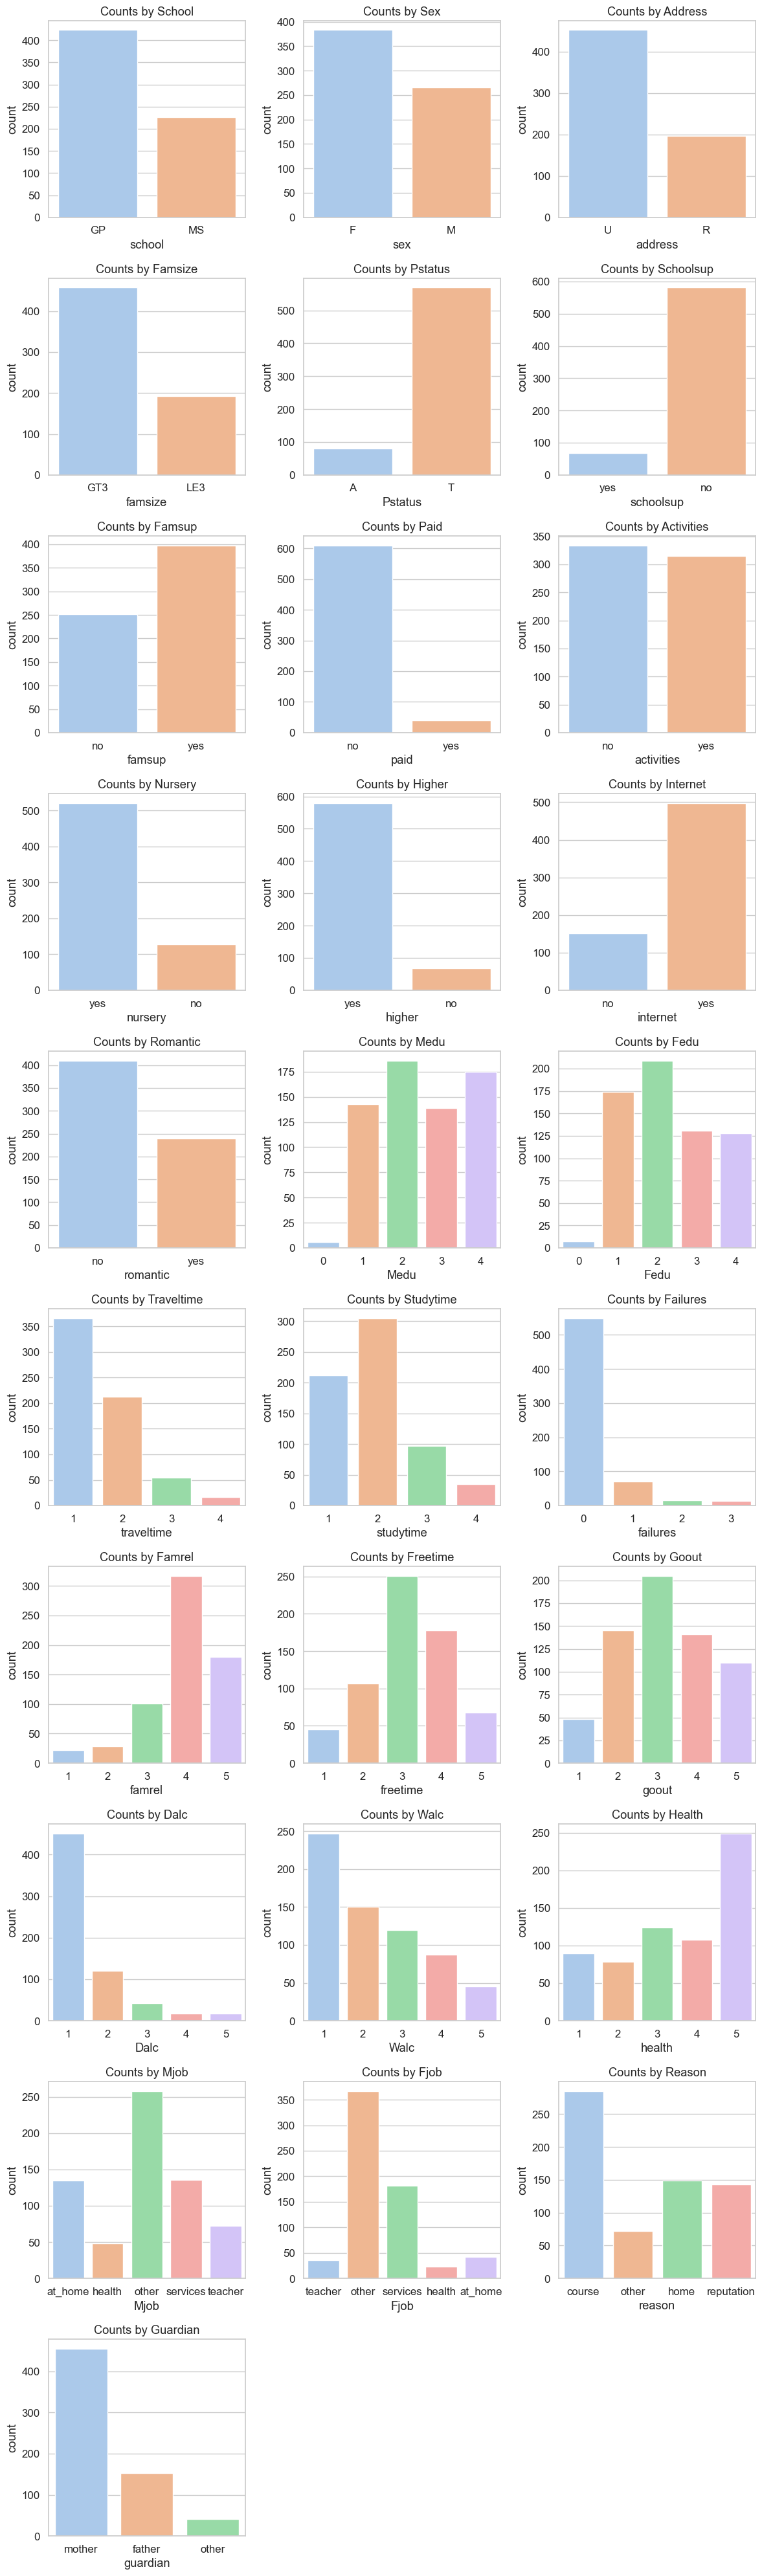

In [34]:
# ------------- Count Plots for Categorical Variables -------------------

# Function to create chart titles
def make_title(var):
    return f"Counts by {var.replace('_', ' ').title()}"

# Plot setup
n_vars = len(cat_vars)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()

# Loop through categorical variables
for i, col in enumerate(cat_vars):
    sns.countplot(x=col, data=df_raw, hue=col, palette="pastel", ax=axes[i])        # Use df_raw to show original categories
    axes[i].set_title(make_title(col))
    if axes[i].get_legend() is not None:
        axes[i].get_legend().remove()

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig("../visualizations/categorical_counts.png", dpi=300, bbox_inches='tight')
plt.show()

### Distributions of Continuous Variables

We check distributions and skewness for continuous variables:

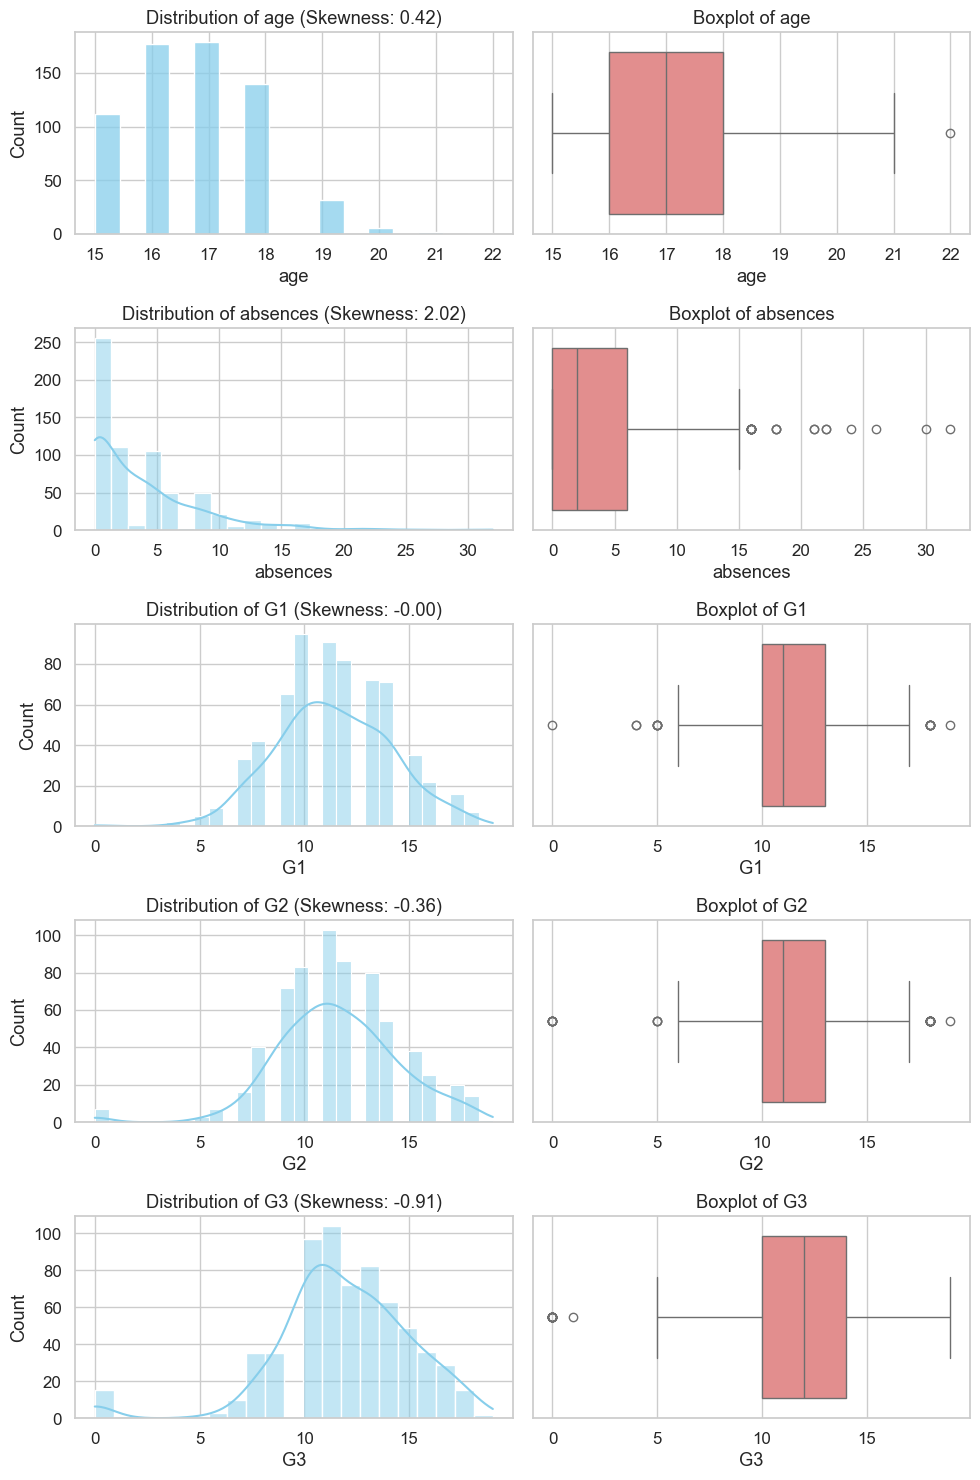

In [35]:
# --------------- Distributions & Skewness of Continuous Variables ----------------

# Set style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

# Plot distributions and boxplots for continuous variables
fig, axes = plt.subplots(len(cont_vars), 2, figsize=(10, 15))
for i, var in enumerate(cont_vars):
    kde_flag = False if var == 'age' else True  # No KDE for age due to discrete nature

    # Histogram with KDE
    sns.histplot(df[var], kde=kde_flag, ax=axes[i, 0], color="skyblue")
    skewness = df[var].skew()
    axes[i, 0].set_title(f"Distribution of {var} (Skewness: {skewness:.2f})")
    
    # Boxplot
    sns.boxplot(x=df[var], ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f"Boxplot of {var}")

plt.tight_layout()
fig.savefig("../visualizations/continuous_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

**Observations**
- Most variables are approximately symmetric, except absences (right-skewed).
- Boxplots reveal outliers in absences and some grades (G1, G2).
- The target G3 is left-skewed, we will address this later

**Interpretation**
- Skewed variables may require transformations in some models.
- Outliers can affect OLS estimates; we'll consider removing them.

### Numeric Relationships with G3

Scatterplots with regression lines show linear associations:

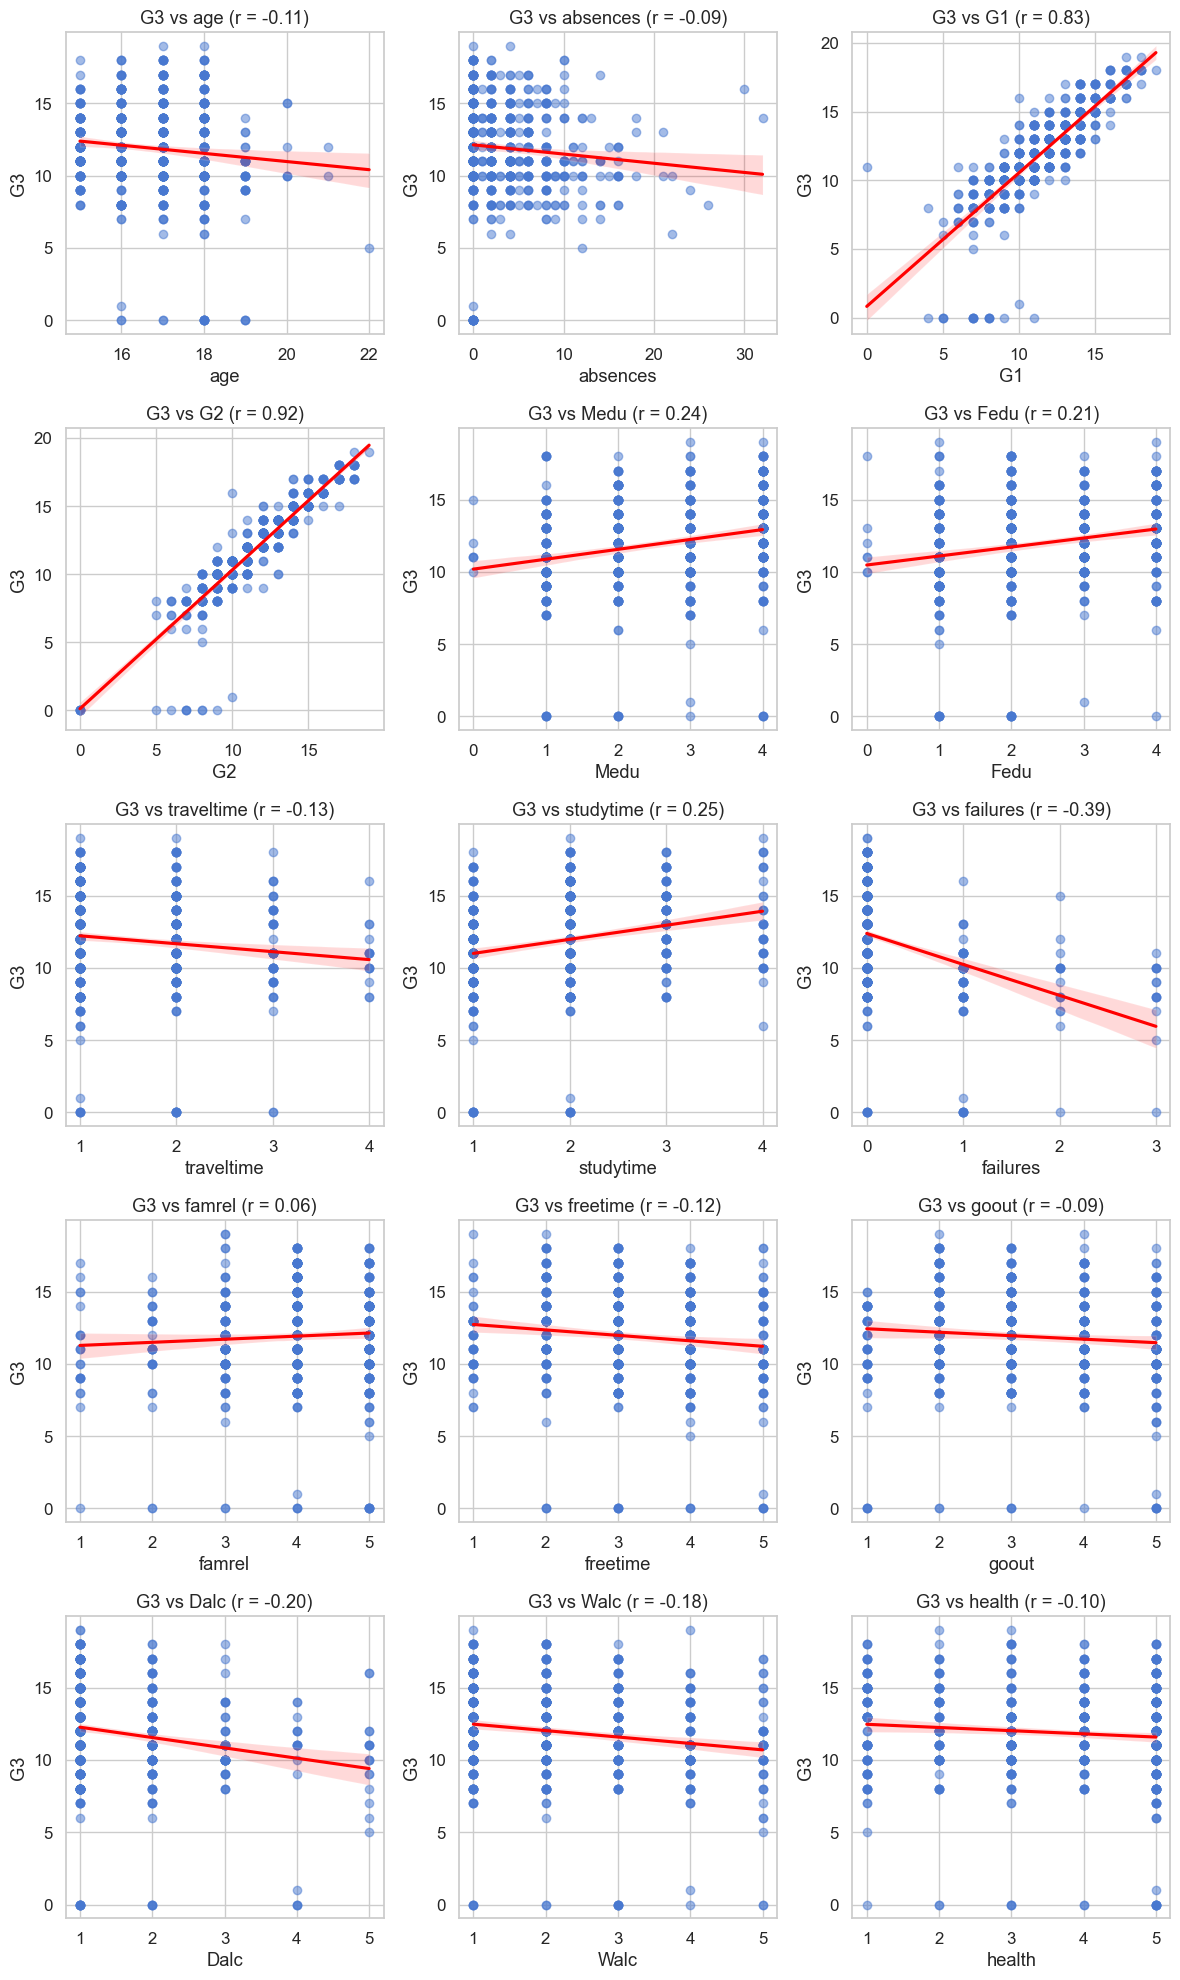

In [36]:
# -------------- Scatter Plots & Regression vs G3 for Numeric Variables ------------------

# Remove 'G3' to avoid plotting vs itself
numeric_vars = [var for var in numeric_vars if var != 'G3']

# Determine grid size
n_vars = len(numeric_vars)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()

# Loop through variables and plot scatter + regression vs G3
for i, col in enumerate(numeric_vars):
    # Calculate correlation coefficient
    r = df[col].corr(df['G3'])
    
    sns.regplot(
        x=col,
        y='G3',
        data=df,
        scatter_kws={'alpha':0.5},
        line_kws={'color':'red'},
        ax=axes[i]
    )
    axes[i].set_title(f"G3 vs {col} (r = {r:.2f})")

# Remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig("../visualizations/scatter_regression_g3.png", dpi=300, bbox_inches='tight')
plt.show()

**Observations:**

- G1 and G2 show the strongest correlation with G3 (r ≈ 0.83 & 0.92).
- Other variables like famrel show weak correlations.

### Pairwise Comparision of Categorical Variables vs G3

Boxplots and barplots summarize mean performance by category:

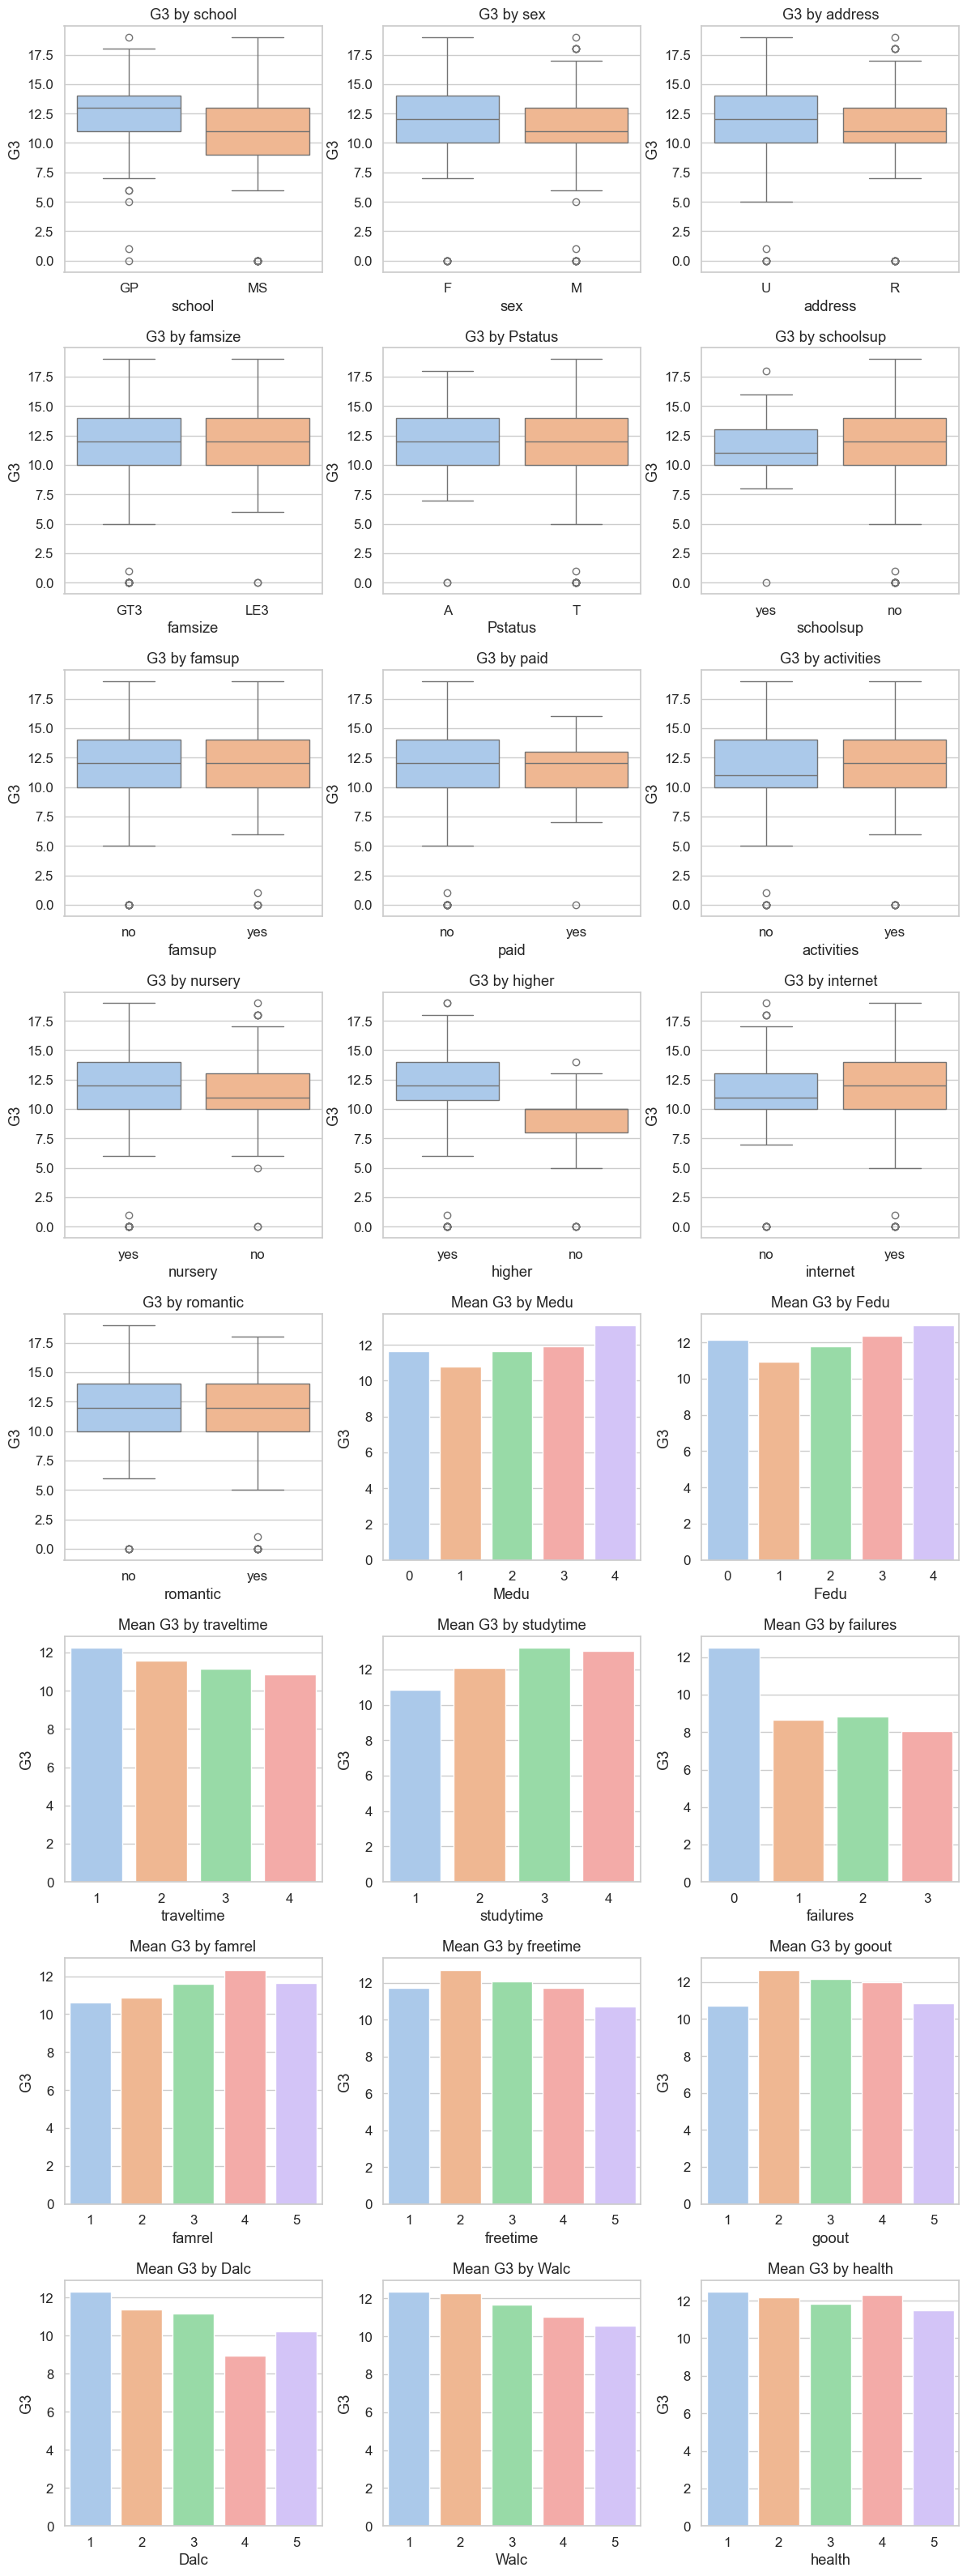

In [37]:
# -------------- Group Comparisons (Boxplots & Bar charts) ----------------
n_vars = len(bin_vars + ord_vars)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
axes = axes.flatten()

for i, var in enumerate(bin_vars + ord_vars):
    ax = axes[i]
    
    # Binary variables (boxplot)
    if var in bin_vars:
        sns.boxplot(x=var, y='G3', data=df_raw, ax=ax, palette='pastel', hue=var)
        ax.set_title(f"G3 by {var}")
    
    # Ordinal variables (barplot of mean G3)
    elif var in ord_vars:
        sns.barplot(x=var, y='G3', data=df_raw, errorbar=None, ax=ax, palette='pastel', hue=var)
        ax.set_title(f"Mean G3 by {var}")
    
    # Remove legend 
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.savefig("../visualizations/group_comparisons.png", dpi=300, bbox_inches='tight')
plt.show()

## Correlation Analysis

### Correlation Matrix

We examine correlations among numeric predictors:

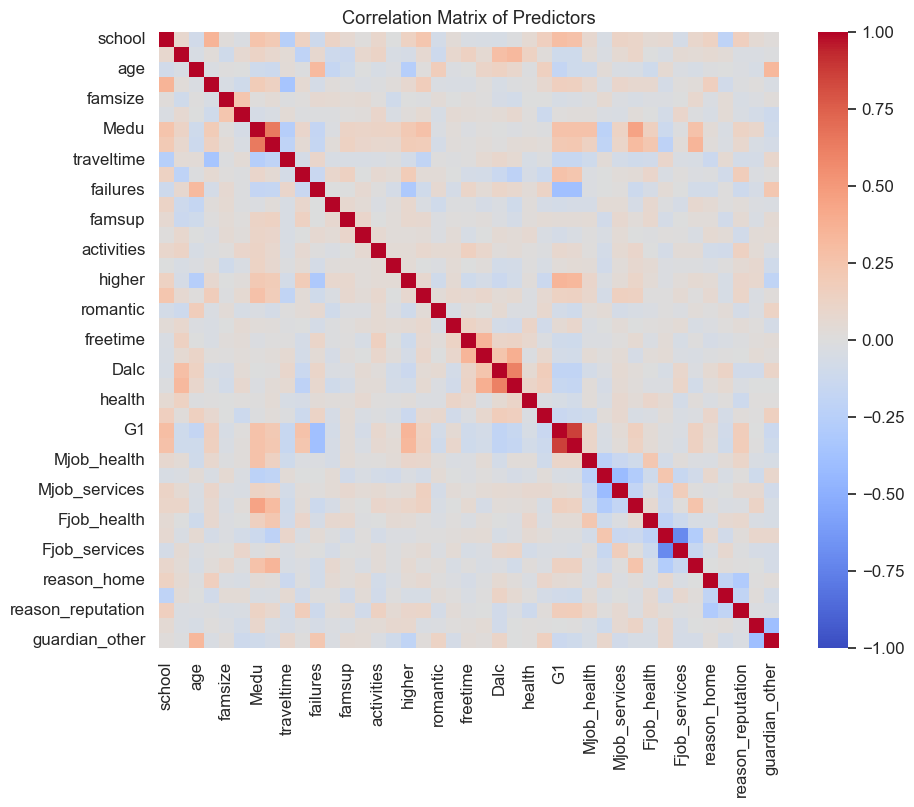

In [38]:
# ----------------- Correlation Matrix for Predictors ----------------

# Encode nominal categorical variables using one-hot encoding
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=nom_vars, drop_first=True)

# Convert any boolean columns to int
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Drop target variable to get predictors only
X = df_encoded.drop(columns='G3')  # predictors only

plt.figure(figsize=(10, 8))
sns.heatmap(
    X.corr(),
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot=False
)
plt.title("Correlation Matrix of Predictors")
plt.savefig("../visualizations/correlation_matrix.png", dpi=300, bbox_inches='tight')   
plt.show()



**Observations**

- High correlation between G1 and G2 may indicate multicollinearity.
- Helps guide feature selection and VIF checks later.

### Association Strength for Categorical Variables

We compute Pearson correlations for binary and eta-squared for multi-category features:

In [39]:
# ----------------- Association Strength for Categorical Variables ----------------

# Identify categorical variables
categorical_cols = df[cat_vars]

results = []

for col in cat_vars:  
    unique_vals = df[col].dropna().unique()

    # Binary variable → use Pearson (point-biserial)
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
        corr, pval = pearsonr(df[col], df['G3'])
        results.append({
            'Variable': col,
            'Type': 'Binary',
            'Correlation': corr,
            'p-value': pval
        })

    # Multi-category variable → use eta-squared (from ANOVA)
    elif len(unique_vals) > 2:
        groups = [df.loc[df[col] == val, 'G3'].dropna() for val in unique_vals]
        f_stat, pval = f_oneway(*groups)
        ss_between = sum(len(g) * (g.mean() - df['G3'].mean())**2 for g in groups)
        ss_total = sum((df['G3'] - df['G3'].mean())**2)
        eta_sq = ss_between / ss_total if ss_total != 0 else np.nan
        results.append({'Variable': col, 'Type': 'Multi-Category', 'Correlation': eta_sq, 'p-value': pval})

# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
results_df['|Correlation|'] = results_df['Correlation'].abs()
results_df = results_df.sort_values(by='|Correlation|', ascending=False)

print("Strength of association between categorical variables and G3:")
print(results_df[['Variable', 'Type', 'Correlation', 'p-value']])

Strength of association between categorical variables and G3:
      Variable            Type  Correlation       p-value
10      higher          Binary     0.332172  3.499660e-18
0       school          Binary     0.284294  1.566199e-13
17    failures  Multi-Category     0.192900  8.644516e-30
2      address          Binary     0.167637  1.764153e-05
11    internet          Binary     0.150025  1.248917e-04
1          sex          Binary    -0.129077  9.815287e-04
12    romantic          Binary    -0.090583  2.100247e-02
16   studytime  Multi-Category     0.068765  5.705728e-10
5    schoolsup          Binary    -0.066405  9.097104e-02
13        Medu  Multi-Category     0.062669  1.885685e-08
8   activities          Binary     0.059791  1.280991e-01
6       famsup          Binary     0.059206  1.318865e-01
7         paid          Binary    -0.054898  1.624412e-01
14        Fedu  Multi-Category     0.048595  1.799114e-06
21        Dalc  Multi-Category     0.048425  1.898967e-06
26      re

**Observations**

We see strong correlation between G3 and higher (pursuit of higher education), school, failures, and address (rural or urban)

### Association of Strength for Numeric Variables

In [40]:
# ----------------- Strength of Association for Numeric (Continuos) Variables ----------------

#  Numeric variables: Pearson correlation with G3
# Dictionary to store results
numeric_results = {}

for col in cont_vars:  # list of numeric predictors
    corr, pval = pearsonr(df[col], df['G3'])
    numeric_results[col] = {'Correlation': corr, 'p-value': pval}

# Convert to DataFrame
numeric_corr_df = pd.DataFrame(numeric_results).T  # transpose so variables are rows
numeric_corr_df = numeric_corr_df.sort_values(by='Correlation', key=abs, ascending=False)  # sort by absolute correlation

print(numeric_corr_df)

          Correlation        p-value
G3           1.000000   0.000000e+00
G2           0.918548  5.642401e-263
G1           0.826387  1.617571e-163
age         -0.106505   6.612115e-03
absences    -0.091379   1.989562e-02


**Observations**

We see strong correlation between G3 and G1, G2

### Combined Association of Strength Plot

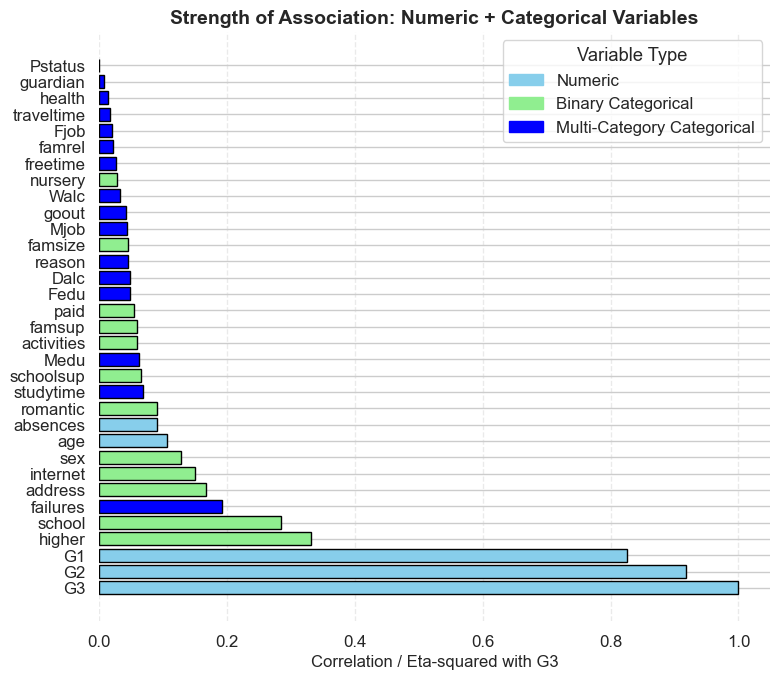

In [41]:
#  ----------------- Combined Bar Plot of Numeric + Categorical Associations ------------------

# Convert numeric_corr_df to match structure of results_df
numeric_plot_df = numeric_corr_df.copy()
numeric_plot_df['Variable'] = numeric_plot_df.index
numeric_plot_df['Type'] = 'Numeric'
numeric_plot_df = numeric_plot_df.reset_index(drop=True)

categorical_plot_df = results_df.copy()
categorical_plot_df = categorical_plot_df.rename(columns={'Correlation': 'Correlation', 'Variable': 'Variable'})

# Combine
combined_df = pd.concat([numeric_plot_df[['Variable', 'Type', 'Correlation']], 
                         categorical_plot_df[['Variable', 'Type', 'Correlation']]])

# Sort for plotting
combined_df['Correlation'] = combined_df['Correlation'].abs()
combined_df = combined_df.sort_values(by='Correlation', key=abs, ascending=True)

# Colors
colors = combined_df['Type'].map({'Numeric': 'skyblue', 'Binary': 'lightgreen', 'Multi-Category': 'blue'})

# Create legend patches
legend_patches = [
    mpatches.Patch(color='skyblue', label='Numeric'),
    mpatches.Patch(color='lightgreen', label='Binary Categorical'),
    mpatches.Patch(color='blue', label='Multi-Category Categorical')
]

# Plot
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

plt.figure(figsize=(8, 7))
plt.barh(
    combined_df['Variable'], 
    combined_df['Correlation'], 
    color=colors,
    edgecolor='black'
)
plt.xlabel('Correlation / Eta-squared with G3', fontsize=12)
plt.title('Strength of Association: Numeric + Categorical Variables', fontsize=14, weight='bold')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.legend(handles=legend_patches, title='Variable Type', loc='upper right')  
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig("../visualizations/combined_association_strength.png", dpi=300, bbox_inches='tight')
plt.show()

**Explanation:**

- Shows the absolute correlation / eta-squared values across all variables.
- Facilitates quick identification of the most influential features.

### Chi Square Tests for Categorical Variables

In [42]:
# --------------- Chi-square Tests for Categorical Variables -----------------

alpha = 0.05  # significance threshold

chi2_results = []

for i in range(len(cat_vars)):
    for j in range(i+1, len(cat_vars)):
        var1 = cat_vars[i]
        var2 = cat_vars[j]

        # Contingency table
        table = pd.crosstab(df[var1], df[var2])
        chi2, p_val, dof, expected = chi2_contingency(table)

        # Cramer's V effect size
        n = table.sum().sum()
        min_dim = min(table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

        chi2_results.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Chi2": round(chi2, 3),
            "p-value": round(p_val, 5),
            "dof": dof,
            "Cramer's V": round(cramers_v, 3)
        })

chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values("p-value").reset_index(drop=True)

print(f"Significant Chi-square results (p < {alpha}):")
display(chi2_df[chi2_df["p-value"] < alpha])
print("Largest effect sizes (Cramer's V):")
display(chi2_df.sort_values("Cramer's V", ascending=False).head(10))


Significant Chi-square results (p < 0.05):


,Variable 1,Variable 2,Chi2,p-value,dof,Cramer's V
0,Dalc,Walc,442.393,0.00000,16,0.413
1,higher,studytime,34.300,0.00000,3,0.230
2,school,Mjob,37.876,0.00000,4,0.242
3,school,reason,52.524,0.00000,3,0.284
4,higher,Medu,30.594,0.00000,4,0.217
...,...,...,...,...,...,...
115,school,sex,4.129,0.04216,1,0.080
116,Medu,guardian,15.925,0.04347,8,0.111
117,activities,internet,4.022,0.04490,1,0.079
118,romantic,Dalc,9.642,0.04692,4,0.122


Largest effect sizes (Cramer's V):


,Variable 1,Variable 2,Chi2,p-value,dof,Cramer's V
0,Dalc,Walc,442.393,0.0,16,0.413
6,Medu,Fedu,388.485,0.0,16,0.387
13,Medu,Mjob,378.368,0.0,16,0.382
16,address,traveltime,81.214,0.0,3,0.354
22,school,address,79.959,0.0,1,0.351
12,sex,Walc,75.113,0.0,4,0.340
18,higher,failures,67.074,0.0,3,0.321
30,school,traveltime,61.120,0.0,3,0.307
8,internet,Mjob,59.580,0.0,4,0.303
11,sex,Dalc,57.774,0.0,4,0.298


**Interpretation**

Althought there are several significant tests to say there may be some correlation between variables, the highest effect size (Cramer's V) is 0.413, which is only a moderate strength of association. We shouldn't have to worry about strong associastions here.

## Inferential Statistics

### T-tests for Binary Categorical Variables vs G3

In [43]:
# ---------------- T-tests for Binary Categorical vs G3 ----------------

alpha = 0.05  # significance threshold

t_results = []

target = 'G3'  # target variable

for var in bin_vars:  # binary predictors
    group0 = df[df[var] == 0][target]
    group1 = df[df[var] == 1][target]

    # Variance ratio
    var0 = np.var(group0, ddof=1)
    var1 = np.var(group1, ddof=1)
    ratio = max(var0, var1) / min(var0, var1)

    # Choose t-test type
    if ratio > 1.5:
        t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
        test_type = "Welch's t-test"
    else:
        t_stat, p_val = ttest_ind(group0, group1, equal_var=True)
        test_type = "Student's t-test"

    # Effect size (Cohen's d)
    mean_diff = group1.mean() - group0.mean()
    pooled_sd = np.sqrt((var0 + var1) / 2)
    cohens_d = mean_diff / pooled_sd

    # Append results
    t_results.append({
        "Binary Variable": var,
        "Target Variable": target,
        "Test Type": test_type,
        "t-statistic": round(t_stat, 3),
        "p-value": round(p_val, 5),
        "Variance Ratio": round(ratio, 2),
        "Group0 Mean": round(group0.mean(), 2),
        "Group1 Mean": round(group1.mean(), 2),
        "Cohen's d": round(cohens_d, 3)
    })

# Convert to DataFrame
t_results_df = pd.DataFrame(t_results)
t_results_df = t_results_df.sort_values("p-value").reset_index(drop=True)

print(f"Significant t-test results (p < {alpha}):")
display(t_results_df[t_results_df["p-value"] < alpha])

Significant t-test results (p < 0.05):


,Binary Variable,Target Variable,Test Type,t-statistic,p-value,Variance Ratio,Group0 Mean,Group1 Mean,Cohen's d
0,school,G3,Welch's t-test,-6.754,0.00000,2.13,10.65,12.58,0.586
1,higher,G3,Student's t-test,-8.958,0.00000,1.06,8.80,12.28,1.153
2,address,G3,Student's t-test,-4.325,0.00002,1.46,11.09,12.26,0.355
3,internet,G3,Student's t-test,-3.860,0.00012,1.22,11.03,12.17,0.349
4,sex,G3,Student's t-test,3.311,0.00098,1.13,12.25,11.41,-0.263
5,romantic,G3,Student's t-test,2.314,0.02100,1.41,12.13,11.52,-0.184
6,schoolsup,G3,Welch's t-test,2.247,0.02675,2.07,11.98,11.28,-0.245


**Observations** 

Students who attend GP school, have internet access, plan for higher education, and live in urban areas tend to achieve significantly higher final grades (G3). Conversely, those receiving school support, in romantic relationships, or female students show slightly lower average grades, though these effects are smaller in magnitude.

### ANOVA Tests for Multi-level Categorical Variables vs G3

In [44]:
# -------------- ANOVA for Multi-level Categorical vs Continuous -----------------

alpha = 0.05
target = 'G3'
anova_results = []

for var in ord_vars:  # ordinal/multi-level categorical predictors
    # Skip variables with less than 2 levels
    if df[var].nunique() < 2:
        continue
    
    # Fit ANOVA model
    model = ols(f"{target} ~ C({var})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    f_stat = anova_table.loc[f"C({var})", "F"]
    p_val = anova_table.loc[f"C({var})", "PR(>F)"]
    
    # Eta-squared: sum_sq_var / sum_sq_total
    eta_sq = anova_table.loc[f"C({var})", "sum_sq"] / anova_table["sum_sq"].sum()
    
    anova_results.append({
        "Categorical Variable": var,
        "Target Variable": target,
        "F-statistic": round(f_stat, 3),
        "p-value": round(p_val, 5),
        "Eta-squared": round(eta_sq, 3)
    })

anova_df = pd.DataFrame(anova_results).sort_values("p-value").reset_index(drop=True)

print(f"Significant ANOVA results (p < {alpha}):")
display(anova_df[anova_df["p-value"] < alpha])

Significant ANOVA results (p < 0.05):


,Categorical Variable,Target Variable,F-statistic,p-value,Eta-squared
0,Medu,G3,10.764,0.00000,0.063
1,Fedu,G3,8.223,0.00000,0.049
2,studytime,G3,15.876,0.00000,0.069
3,failures,G3,51.386,0.00000,0.193
4,Dalc,G3,8.193,0.00000,0.048
5,goout,G3,6.986,0.00002,0.042
6,Walc,G3,5.535,0.00022,0.033
7,freetime,G3,4.489,0.00139,0.027
8,famrel,G3,3.678,0.00568,0.022
9,traveltime,G3,3.659,0.01232,0.017


**Observations**

Students’ final grades (G3) vary significantly across several multi-level factors: higher parental education, more study time, and fewer past failures are strongly linked to better performance, while frequent alcohol use, more going out, and longer travel times are associated with lower grades. Overall, failures and studytime show the largest effect sizes (η² ≈ 0.19 and 0.07).

## Checking Model Assumptions

### Normal Distribution of Target Variable

We being by checking if the target variable 'G3' is normally distributed:

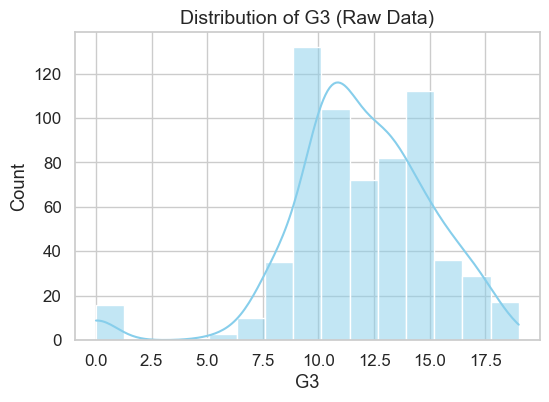

Raw skewness: -0.91 | Raw kurtosis: 2.71
Shapiro–Wilk (raw): W = 0.926, p = 0.0000


In [45]:
# ------------------ Check Distribution of 'G3' ------------------

target = 'G3'

# Plot distribution of target variable (raw)
plt.figure(figsize=(6,4))
sns.histplot(df[target], kde=True, color='skyblue', bins=15)
plt.title(f"Distribution of {target} (Raw Data)", fontsize=14)
plt.xlabel(target)
plt.ylabel("Count")
plt.savefig("../visualizations/g3_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Skewness and kurtosis (raw)
skew_val_raw = df[target].skew()
kurt_val_raw = df[target].kurtosis()
print(f"Raw skewness: {skew_val_raw:.2f} | Raw kurtosis: {kurt_val_raw:.2f}")

# Shapiro–Wilk test (raw)
shapiro_stat, shapiro_p = stats.shapiro(df[target])
print(f"Shapiro–Wilk (raw): W = {shapiro_stat:.3f}, p = {shapiro_p:.4f}")

**Interpretation**

G3 is clearly right-skewed, we will need to see if removing the outliers makes the distribution more normal.


Number of potential outliers: 16


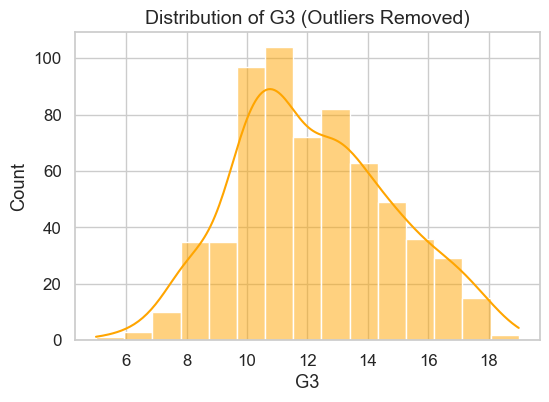

After removing outliers: skewness = 0.23, kurtosis = -0.47
Shapiro–Wilk (no outliers): W = 0.976, p = 0.0000


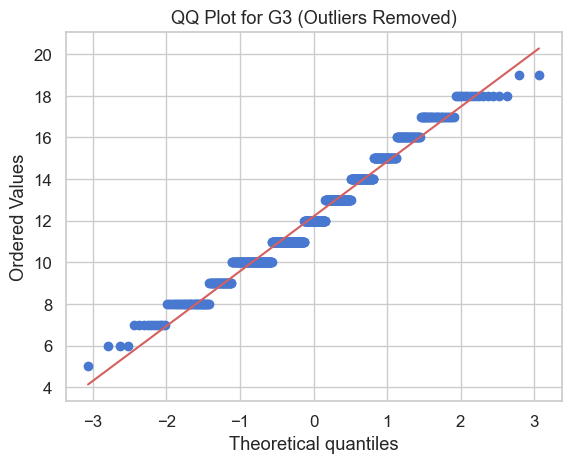

In [46]:
# ------------------ Remove G3 Outliers and Check Distribution Again------------------

# Outlier Detection (IQR method) 
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]
print(f"\nNumber of potential outliers: {len(outliers)}")

# Remove outliers
df_no_outliers = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]

# Distribution and Normality (after outlier remova) 
plt.figure(figsize=(6,4))
sns.histplot(df_no_outliers[target], kde=True, color='orange', bins=15)
plt.title(f"Distribution of {target} (Outliers Removed)", fontsize=14)
plt.savefig("../visualizations/g3_distribution_no_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

# Skewness and kurtosis (after outlier removal)
skew_val = df_no_outliers[target].skew()
kurt_val = df_no_outliers[target].kurtosis()
print(f"After removing outliers: skewness = {skew_val:.2f}, kurtosis = {kurt_val:.2f}")

# Shapiro–Wilk (after outlier removal)
shapiro_stat, shapiro_p = stats.shapiro(df_no_outliers[target])
print(f"Shapiro–Wilk (no outliers): W = {shapiro_stat:.3f}, p = {shapiro_p:.4f}")

# QQ plot for visual check
stats.probplot(df_no_outliers[target], dist="norm", plot=plt)
plt.title(f"QQ Plot for {target} (Outliers Removed)")
plt.savefig("../visualizations/g3_qqplot_no_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

**Observations** 

Removing the outliers helped shape G3 to be more normally distributed.  G3 shifted from heavily left skewed to slightly right skewed.  Even though G3 with outliers removed still doesn't pass the Shapiro-Wilk significance test, the QQ plot for G3 gives enough reason to suggest we can assume a normally distributed target variable

### Multicollinearity of Categorical Predictors

In [47]:
# ------------------ Check Multicollinearity (VIF) with One-hot Encoded Multi-category Predictors ------------------

# X = predictors only (after one-hot encoding)
X = df_encoded.drop(columns=['G3'])
X = sm.add_constant(X)  # add intercept

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort descending for readability
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

# Display top 10 largest VIFs
display(vif_data.head(10))

,Variable,VIF
0,const,378.218504
1,Fjob_other,4.677847
2,G1,4.430493
3,G2,4.307080
4,Fjob_services,4.227396
5,Medu,2.693316
6,Mjob_teacher,2.277617
7,Fjob_teacher,2.178296
8,Walc,2.113194
9,Mjob_services,2.113154


**Interpretation**

The variance inflation factor (VIF) analysis indicates that multicollinearity among the predictor variables is generally low. All predictors exhibit VIF values below 5, suggesting that redundancy between variables is minimal and should not adversely affect the stability of the regression estimates. The exceptionally high VIF for the intercept (const) is expected and does not indicate multicollinearity among the predictors.

### Residual Distribution of Numeric Variables

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     140.9
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          6.51e-276
Time:                        15:13:07   Log-Likelihood:                -763.79
No. Observations:                 633   AIC:                             1612.
Df Residuals:                     591   BIC:                             1799.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3629      0.64

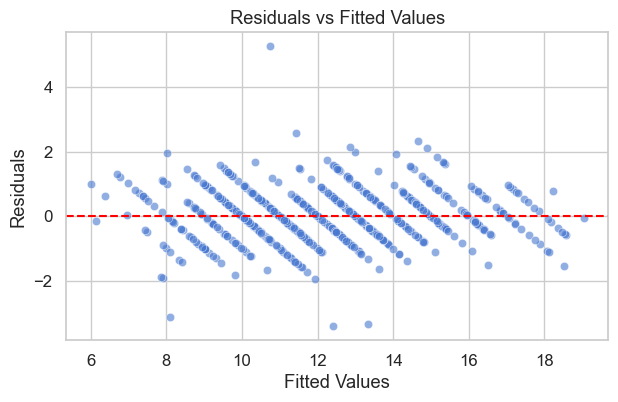

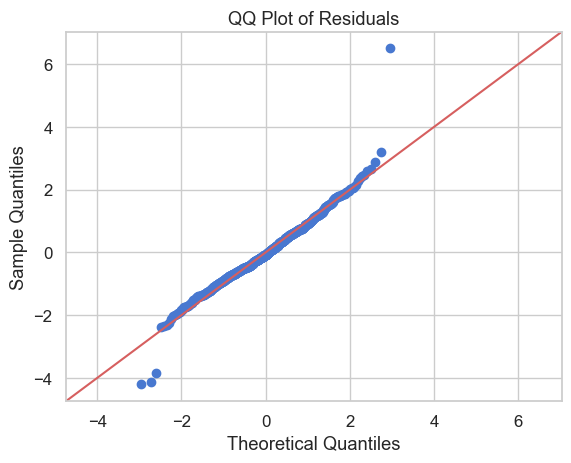

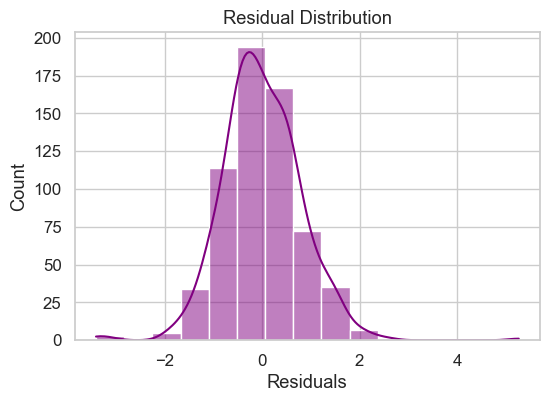

In [48]:
# ------------------ Fit Preliminary OLS Model to Check Residuals ------------------

# Predictors (with one-hot encoding) and target
X = df_encoded.drop(columns=['G3'])
X = sm.add_constant(X)              # add intercept
y = df_no_outliers['G3']            # remove outliers

# Fit model
prelim_model = sm.OLS(y, X.loc[y.index]).fit()  # align indices since using outlier-cleaned y

# Residuals
residuals = prelim_model.resid
fitted = prelim_model.fittedvalues

# Summary
print(prelim_model.summary())

# Residual Plots 

plt.figure(figsize=(7,4))
sns.scatterplot(x=fitted, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.savefig("../visualizations/residuals_vs_fitted.png", dpi=300, bbox_inches='tight')
plt.show()

# QQ Plot of residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.savefig("../visualizations/qqplot_residuals.png", dpi=300, bbox_inches='tight')
plt.show()

# Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='purple', bins=15)
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.savefig("../visualizations/residuals_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

**Interpretation**

The residuals of the numerical features appear to be normally distributed.

### Heteroscedasticity

In [49]:
#  --------------- Test for Heteroscedasticity (Breusch-Pagan) ------------------

# Residuals and predictors from preliminary OLS model
lm = prelim_model  # your OLS model

# Run Breusch-Pagan test
bp_test = het_breuschpagan(lm.resid, lm.model.exog)
bp_labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']

print("Breusch-Pagan Test for Heteroscedasticity:")
for label, value in zip(bp_labels, bp_test):
    print(f"{label}: {value:.4f}")

Breusch-Pagan Test for Heteroscedasticity:
LM Statistic: 67.3687
LM p-value: 0.0058
F-Statistic: 1.7168
F p-value: 0.0043


**Observation**

The test indicates significant heteroscedasticity, as evidenced by p-values near zero, leading to rejection of the null hypothesis. Consequently, OLS estimates may have inefficient standard errors; it is recommended to use robust standard errors and consider alternative modeling approaches that are less sensitive to heteroscedasticity, such as tree-based methods like Random Forest or Gradient Boosting.

## Modeling

### Feature Engineering

We will test an OLS model with few interaction terms to see if we should include them in our final model:

In [50]:
# ------------------- Feature Engineering & Interaction Terms -------------------
X_test_fe = df_encoded.drop(columns=['G3']).copy()
y_test_fe = df_no_outliers['G3']
X_test_fe = X_test_fe.loc[y_test_fe.index]

# 1. Performance improvement (abs difference between G1 and G2)
X_test_fe['G_perf_improve'] = abs(df_no_outliers['G2'] - df_no_outliers['G1'])

# 2. Average past performance (G1 + G2)/2
X_test_fe['G_avg'] = (df_no_outliers['G1'] + df_no_outliers['G2']) / 2

# 3. Interaction term (studytime * failures)
if 'studytime' in X_test_fe.columns and 'failures' in X_test_fe.columns:
    X_test_fe['studytime_failures'] = X_test_fe['studytime'] * X_test_fe['failures']

# 4. Interaction term (absences * studytime)
if 'absences' in X_test_fe.columns and 'studytime' in X_test_fe.columns:
    X_test_fe['absences_studytime'] = X_test_fe['absences'] * X_test_fe['studytime']

# ------------------- Train/Test Split -------------------
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_test_fe, y_test_fe, test_size=0.2, random_state=42
)

# ------------------- OLS: Baseline -------------------
X_sm_base = sm.add_constant(X_train_fe.drop(columns=['G_perf_improve','studytime_failures','G_avg','absences_studytime']))
ols_base = sm.OLS(y_train_fe, X_sm_base).fit()
y_pred_base = ols_base.predict(sm.add_constant(X_test_fe.drop(columns=['G_perf_improve','studytime_failures','G_avg','absences_studytime'])))

print("Baseline OLS Test R2:", r2_score(y_test_fe, y_pred_base))
print("Baseline OLS Test RMSE:", mean_squared_error(y_test_fe, y_pred_base) ** 0.5)

# ------------------- OLS: With Feature-Engineered Terms -------------------
X_sm_fe = sm.add_constant(X_train_fe)
ols_fe = sm.OLS(y_train_fe, X_sm_fe).fit()
y_pred_fe = ols_fe.predict(sm.add_constant(X_test_fe))

print("FE OLS Test R2:", r2_score(y_test_fe, y_pred_fe))
print("FE OLS Test RMSE:", mean_squared_error(y_test_fe, y_pred_fe) ** 0.5)

Baseline OLS Test R2: 0.8949719417225516
Baseline OLS Test RMSE: 0.8717123735429568
FE OLS Test R2: 0.8940081828334319
FE OLS Test RMSE: 0.8757027456172547


**Observation**

The test set results show no improvement after adding the feature-engineered and interaction terms. R² and RMSE are largely unchanged, indicating these features do not add meaningful predictive value.

### Comparing Models

We will use all predictors to choose the best model between OLS, Lasso, Ridge, Random Forest, and Gradient Boosting:

,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2
0,OLS,0.800243,0.871712,0.908518,0.894972
1,Lasso,0.848957,0.890324,0.897041,0.890439
2,Ridge,0.802309,0.877693,0.908045,0.893526
3,Random Forest,0.334208,0.861520,0.984044,0.897414
4,Gradient Boosting,0.425179,0.868352,0.974175,0.895780


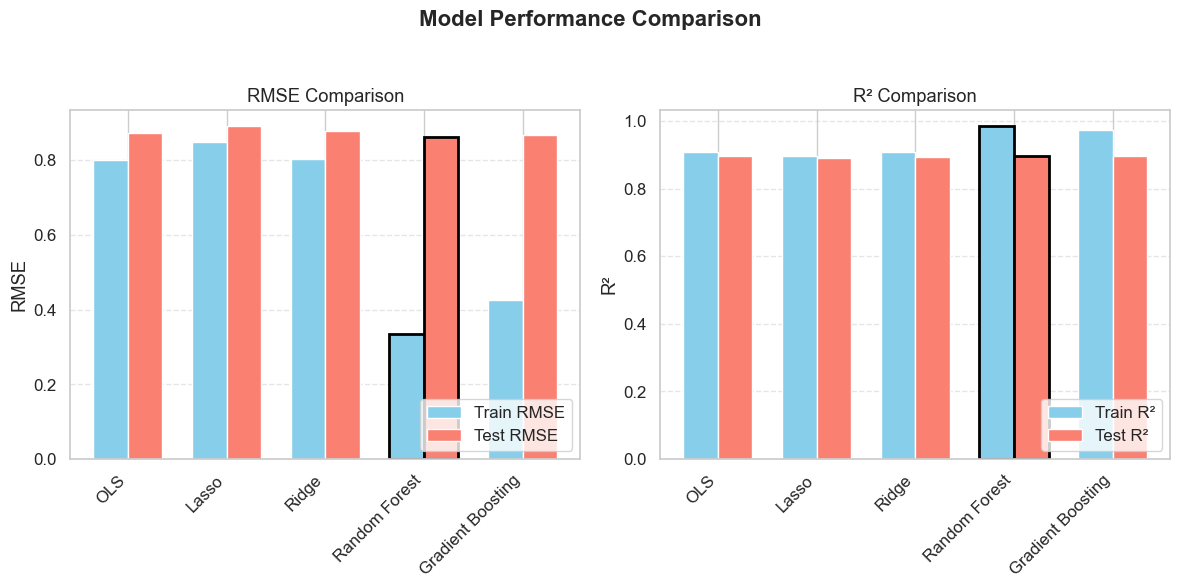

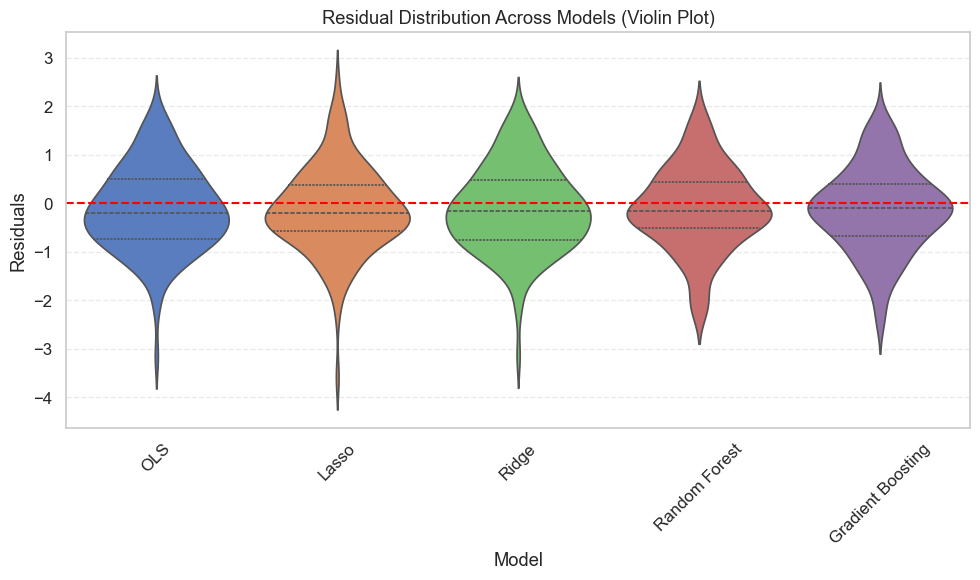

In [51]:
# ------------------- Data -------------------
X = df_encoded.drop(columns=['G3'])
y = df_no_outliers['G3']  # keep outlier removal
X = X.loc[y.index]

# Train/test split with random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize results container 
results = []

# ------------------- 1. Scaled OLS -------------------

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Add constant for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled  = sm.add_constant(X_test_scaled)

# Fit OLS on scaled features
ols_model = sm.OLS(y_train, X_train_scaled).fit(cov_type='HC3') # robust SEs

# Predictions
y_pred_train_ols = ols_model.predict(X_train_scaled)
y_pred_test_ols  = ols_model.predict(X_test_scaled)

results.append({
    "Model": "OLS",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ols) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ols) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ols),
    "Test_R2": r2_score(y_test, y_pred_test_ols)
})

# ------------------- 2. Lasso -------------------
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_

y_pred_train_lasso = best_lasso.predict(X_train)
y_pred_test_lasso  = best_lasso.predict(X_test)

results.append({
    "Model": "Lasso",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_lasso) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_lasso) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_lasso),
    "Test_R2": r2_score(y_test, y_pred_test_lasso)
})

# ------------------- 3. Ridge -------------------
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

y_pred_train_ridge = best_ridge.predict(X_train)
y_pred_test_ridge  = best_ridge.predict(X_test)

results.append({
    "Model": "Ridge",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ridge) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ridge) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ridge),
    "Test_R2": r2_score(y_test, y_pred_test_ridge)
})

# ------------------- 4. Random Forest -------------------
rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf  = rf.predict(X_test)

results.append({
    "Model": "Random Forest",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_rf) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_rf) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_rf),
    "Test_R2": r2_score(y_test, y_pred_test_rf)
})

# ------------------- 5. Gradient Boosting -------------------
gb = GradientBoostingRegressor(random_state=42, n_estimators=200)
gb.fit(X_train, y_train)

y_pred_train_gb = gb.predict(X_train)
y_pred_test_gb  = gb.predict(X_test)

results.append({
    "Model": "Gradient Boosting",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_gb) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_gb) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_gb),
    "Test_R2": r2_score(y_test, y_pred_test_gb)
})

# ------------------- Convert results to DataFrame -------------------
results_df = pd.DataFrame(results)
display(results_df)

# ------------------- Plot comparisons -------------------

# Determine the best model (lowest Test RMSE)
best_idx = results_df['Test_RMSE'].idxmin()

# Bar width and positions
x = np.arange(len(results_df['Model']))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Colors
train_color = 'skyblue'
test_color = 'salmon'
highlight_edge = 'black'

# RMSE Comparison
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[0].bar(x[i] - width/2, results_df['Train_RMSE'][i], width=width, color=train_color, edgecolor=edge, linewidth=2 if edge else 1, label='Train RMSE' if i==0 else "")
    axes[0].bar(x[i] + width/2, results_df['Test_RMSE'][i], width=width, color=test_color, edgecolor=edge, linewidth=2 if edge else 1, label='Test RMSE' if i==0 else "")

axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].legend(loc='lower right')

# R² Comparison
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[1].bar(x[i] - width/2, results_df['Train_R2'][i], width=width, color=train_color, edgecolor=edge, linewidth=2 if edge else 1, label='Train R²' if i==0 else "")
    axes[1].bar(x[i] + width/2, results_df['Test_R2'][i], width=width, color=test_color, edgecolor=edge, linewidth=2 if edge else 1, label='Test R²' if i==0 else "")

axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R²")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].legend(loc='lower right')

plt.suptitle("Model Performance Comparison", fontsize=16, weight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("../visualizations/model_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------- Violin Plot ----------------
residuals_dict = {
    "OLS": y_test - y_pred_test_ols,
    "Lasso": y_test - y_pred_test_lasso,
    "Ridge": y_test - y_pred_test_ridge,
    "Random Forest": y_test - y_pred_test_rf,
    "Gradient Boosting": y_test - y_pred_test_gb
}

plt.figure(figsize=(10,6))
sns.violinplot(
    data=pd.DataFrame(residuals_dict),  
    palette="muted",
    inner="quartile"
)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Distribution Across Models (Violin Plot)")
plt.ylabel("Residuals")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("../visualizations/residuals_violin_plot.png", dpi=300, bbox_inches='tight')
plt.show()

**Explanation**

We selected the Random Forest as the best-performing model because it achieved the lowest test set RMSE. The violin plots show that its residuals are tightly clustered around zero, with a narrow, symmetric shape and the shortest range among models, indicating accurate predictions with low variance.

A test R² of 0.897 indicates that approximately 89.7% of the variance in the target variable is explained by the model on unseen data. This suggests a very strong predictive performance, meaning the model captures most of the systematic patterns in the data, with only about 10% of the variance left unexplained.

A test RMSE of 0.861 indicates that, on average, the model’s predictions deviate from the true values by about 0.86 units. Combined with a high R², this shows that the model predicts the target variable accurately, with relatively small errors.

### Interpreting the Best Model (Random Forest)

Best model selected based on Test RMSE: Random Forest


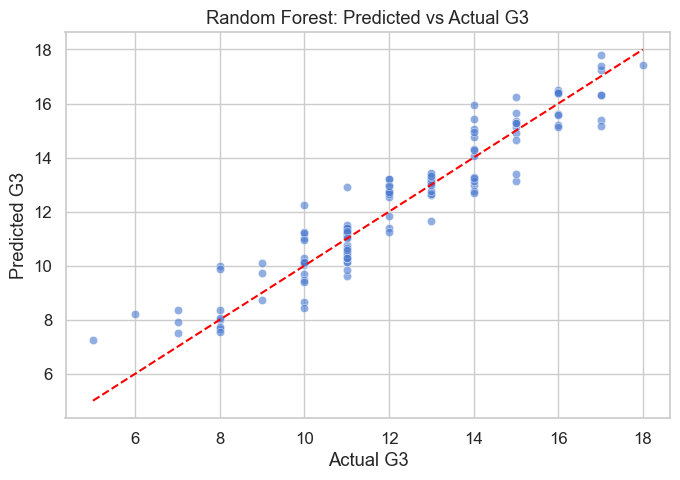

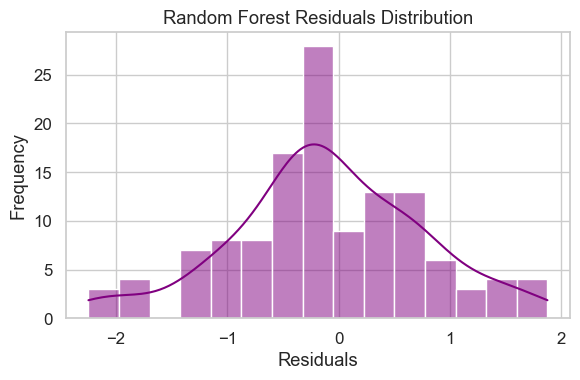

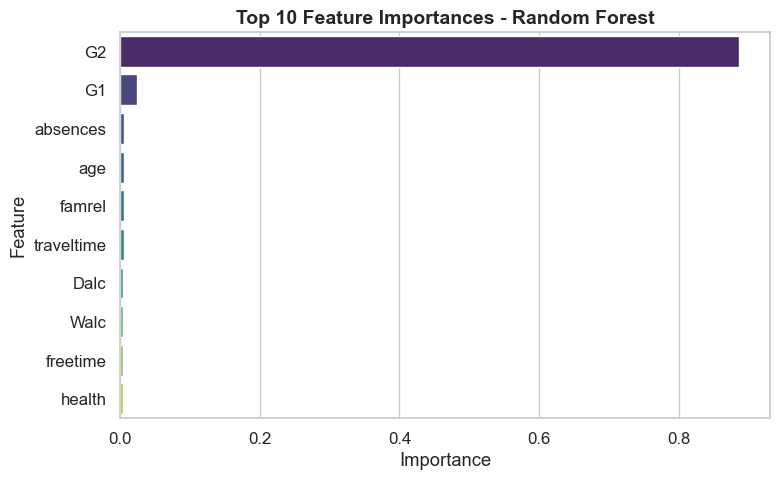

Top 10 important features:


G2            0.886439
G1            0.024254
absences      0.006254
age           0.005706
famrel        0.005571
traveltime    0.005500
Dalc          0.004274
Walc          0.004050
freetime      0.004038
health        0.004022
dtype: float64

In [52]:
# ------------------ Random Forest Interpretation ------------------

# Identify the best model index
best_idx = results_df['Test_RMSE'].idxmin()
best_model_name = results_df.loc[best_idx, 'Model']
print(f"Best model selected based on Test RMSE: {best_model_name}")

# ------------------ Predictions vs Actuals ------------------
y_pred_rf = rf.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title("Random Forest: Predicted vs Actual G3")
plt.tight_layout()
plt.savefig("../visualizations/rf_predicted_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------ Residuals ------------------
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(6,4))
sns.histplot(residuals_rf, kde=True, color='purple', bins=15)
plt.title("Random Forest Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../visualizations/rf_residuals_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------ Top 10 Feature Importances (Random Forest) ------------------
if best_model_name == "Random Forest":
    rf_importances = rf.feature_importances_
    feat_importance = pd.Series(rf_importances, index=X.columns).sort_values(ascending=False)

    top_10_features = feat_importance.head(10)

    plt.figure(figsize=(8,5))
    sns.barplot(
    x=top_10_features.values, 
    y=top_10_features.index, 
    hue=top_10_features.index,  
    palette="viridis",
    legend=False                 
    )
    plt.title("Top 10 Feature Importances - Random Forest", fontsize=14, weight='bold')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig("../visualizations/rf_top_10_feature_importances.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("Top 10 important features:")
    display(top_10_features)

**Interpretation**

The model’s residuals are approximately normal and homoscedastic. The strongest predictors of G3 are G2, G1, absences, and age.

### Comparing Models (again) `Without` 'G1' and 'G2' as Predictors

We will remove 'G1' and 'G2' and choose the best model between OLS, Lasso, Ridge, Random Forest, and Gradient Boosting:

,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2
0,OLS,2.076106,2.122731,0.384270,0.377200
1,Lasso,2.128481,2.161344,0.352812,0.354336
2,Ridge,2.087657,2.101231,0.377399,0.389752
3,Random Forest,0.815488,2.146161,0.904999,0.363375
4,Gradient Boosting,1.186433,2.231479,0.798916,0.311753


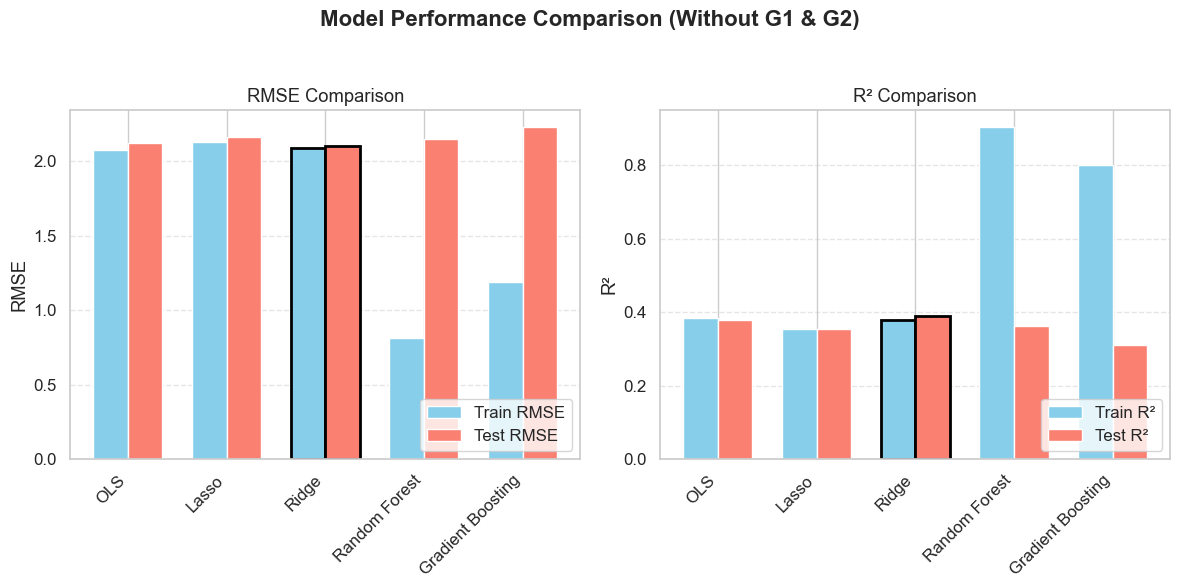

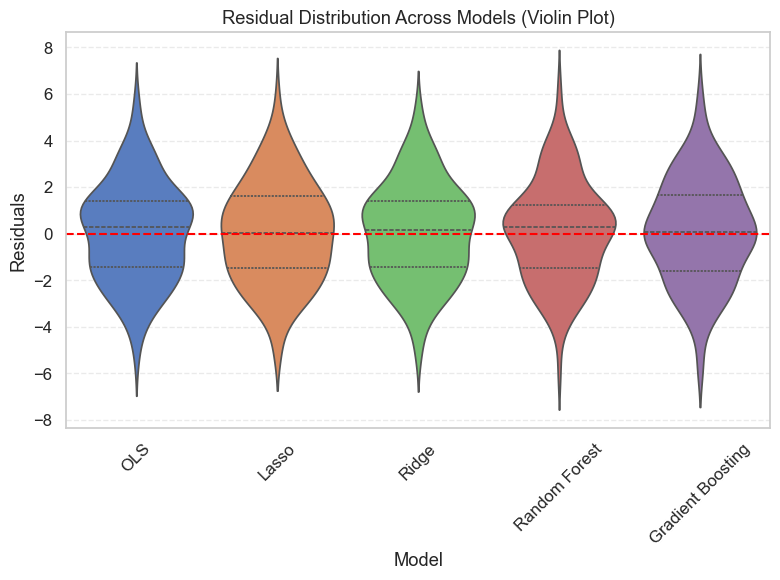

In [53]:
# ------------------- Data (remove G1 and G2) -------------------
X = df_encoded.drop(columns=['G3', 'G1', 'G2'])
y = df_no_outliers['G3']  # keep outlier removal
X = X.loc[y.index]

# Train/test split with random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize results container 
results = []

# ------------------- 1. Scaled OLS -------------------

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Add constant for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled  = sm.add_constant(X_test_scaled)

# Fit OLS on scaled features
ols_model = sm.OLS(y_train, X_train_scaled).fit(cov_type='HC3') # robust SEs

# Predictions
y_pred_train_ols = ols_model.predict(X_train_scaled)
y_pred_test_ols  = ols_model.predict(X_test_scaled)

results.append({
    "Model": "OLS",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ols) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ols) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ols),
    "Test_R2": r2_score(y_test, y_pred_test_ols)
})

# ------------------- 2. Lasso -------------------
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_

y_pred_train_lasso = best_lasso.predict(X_train)
y_pred_test_lasso  = best_lasso.predict(X_test)

results.append({
    "Model": "Lasso",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_lasso) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_lasso) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_lasso),
    "Test_R2": r2_score(y_test, y_pred_test_lasso)
})

# ------------------- 3. Ridge -------------------
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

y_pred_train_ridge = best_ridge.predict(X_train)
y_pred_test_ridge  = best_ridge.predict(X_test)

results.append({
    "Model": "Ridge",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ridge) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ridge) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ridge),
    "Test_R2": r2_score(y_test, y_pred_test_ridge)
})

# ------------------- 4. Random Forest -------------------
rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf  = rf.predict(X_test)

results.append({
    "Model": "Random Forest",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_rf) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_rf) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_rf),
    "Test_R2": r2_score(y_test, y_pred_test_rf)
})

# ------------------- 5. Gradient Boosting -------------------
gb = GradientBoostingRegressor(random_state=42, n_estimators=200)
gb.fit(X_train, y_train)

y_pred_train_gb = gb.predict(X_train)
y_pred_test_gb  = gb.predict(X_test)

results.append({
    "Model": "Gradient Boosting",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_gb) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_gb) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_gb),
    "Test_R2": r2_score(y_test, y_pred_test_gb)
})

# ------------------- Convert results to DataFrame -------------------
results_df = pd.DataFrame(results)
display(results_df)

# ------------------- Plot comparisons -------------------
best_idx = results_df['Test_RMSE'].idxmin()
x = np.arange(len(results_df['Model']))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(12,6))
train_color = 'skyblue'
test_color = 'salmon'
highlight_edge = 'black'

# RMSE
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[0].bar(x[i] - width/2, results_df['Train_RMSE'][i], width=width, color=train_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Train RMSE' if i==0 else "")
    axes[0].bar(x[i] + width/2, results_df['Test_RMSE'][i], width=width, color=test_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Test RMSE' if i==0 else "")

axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].legend(loc='lower right')

# R²
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[1].bar(x[i] - width/2, results_df['Train_R2'][i], width=width, color=train_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Train R²' if i==0 else "")
    axes[1].bar(x[i] + width/2, results_df['Test_R2'][i], width=width, color=test_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Test R²' if i==0 else "")

axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R²")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].legend(loc='lower right')

plt.suptitle("Model Performance Comparison (Without G1 & G2)", fontsize=16, weight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig("../visualizations/model_performance_comparison_no_g1_g2.png", dpi=300, bbox_inches='tight')
plt.show()

# ---------------- Violin Plot ----------------
residuals_dict = {
    "OLS": y_test - y_pred_test_ols,
    "Lasso": y_test - y_pred_test_lasso,
    "Ridge": y_test - y_pred_test_ridge,
    "Random Forest": y_test - y_pred_test_rf,
    "Gradient Boosting": y_test - y_pred_test_gb
}

plt.figure(figsize=(8,6))
sns.violinplot(
    data=pd.DataFrame(residuals_dict),  # use wide-form directly
    palette="muted",
    inner="quartile"
)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Distribution Across Models (Violin Plot)")
plt.ylabel("Residuals")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("../visualizations/residuals_violin_plot_no_g1_g2.png", dpi=300, bbox_inches='tight')
plt.show()

**Explanation**

We selected Ridge regression as the best-performing model because it achieved the lowest test set RMSE. The violin plots show that its residuals are tightly clustered around zero, with short tails indicating a small range of errors. Although the zero line runs through the center of the Lasso residuals as well, Ridge was preferred due to its slightly lower RMSE, reflected in the narrower distribution of residuals.

As expected, the predictive power of this model with G1 and G2 removed is much lower (r2 = .39), although the purpose is to analyze how the other feature importances will change without the G1 and G2 predictors.  We will do this next.

### Interpreting Best Model (again) `Without` 'G1' and 'G2' as Predictors (Ridge)

Best model selected based on Test RMSE: Ridge


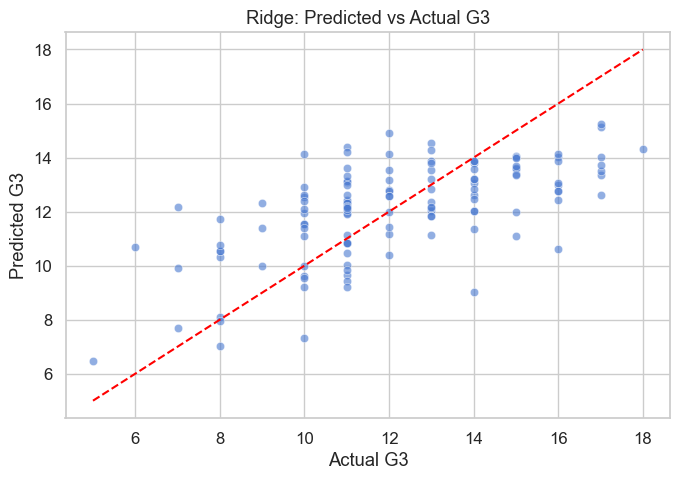

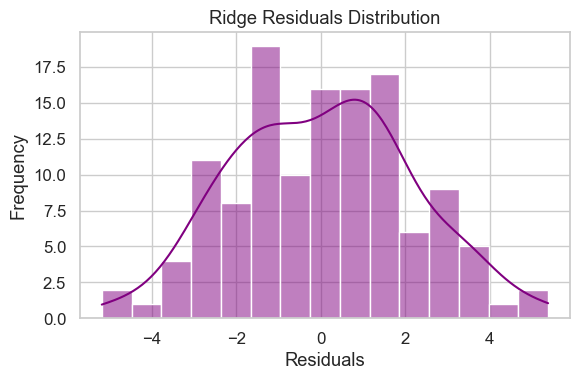

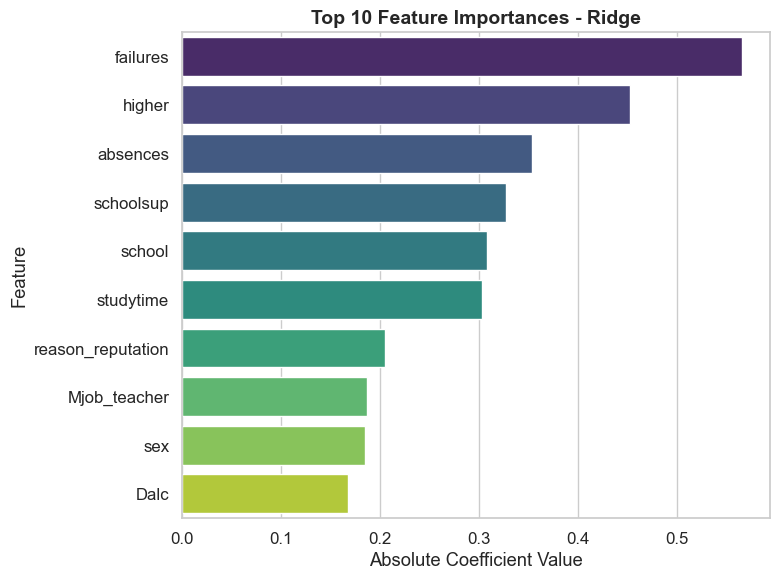

Top 10 important features:


failures             0.565870
higher               0.452681
absences             0.353691
schoolsup            0.326584
school               0.307403
studytime            0.302993
reason_reputation    0.204352
Mjob_teacher         0.186747
sex                  0.184888
Dalc                 0.167625
dtype: float64

In [54]:
# ------------------ Ridge Model Interpretation ------------------

# Identify the best model index
best_idx = results_df['Test_RMSE'].idxmin()
best_model_name = results_df.loc[best_idx, 'Model']
print(f"Best model selected based on Test RMSE: {best_model_name}")

# ------------------ Predictions vs Actuals ------------------
# Use Ridge predictions
y_pred_ridge = best_ridge.predict(X_test)

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title("Ridge: Predicted vs Actual G3")
plt.tight_layout()
plt.savefig("../visualizations/ridge_predicted_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------ Residuals ------------------
residuals_ridge = y_test - y_pred_ridge

plt.figure(figsize=(6,4))
sns.histplot(residuals_ridge, kde=True, color='purple', bins=15)
plt.title("Ridge Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../visualizations/ridge_residuals_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------ Top 10 Feature Importances (Ridge) ------------------
if best_model_name == "Ridge":
    ridge_coefs = best_ridge.named_steps['ridge'].coef_
    feat_importance = pd.Series(ridge_coefs, index=X.columns).abs().sort_values(ascending=False)

    top_10_features = feat_importance.head(10)

    plt.figure(figsize=(8,6))
    sns.barplot(
    x=top_10_features.values, 
    y=top_10_features.index, 
    hue=top_10_features.index,  
    palette="viridis",
    legend=False                 
    )
    plt.title("Top 10 Feature Importances - Ridge", fontsize=14, weight='bold')
    plt.xlabel("Absolute Coefficient Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig("../visualizations/ridge_top_10_feature_importances.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("Top 10 important features:")
    display(top_10_features)


**Interpretation:**

The model’s residuals are approximately normal and homoscedastic. The strongest predictors in this model with G1 and G2 removed are now failuers, higher (pursuit of higher education), absences, schoolsup (level of academic support), and school.